In [1]:
import time

import matplotlib.pyplot as plt

import numpy as np

import pandas

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
    
def confusion_matrix(Y_classes, Ttest):
    classes = np.unique(Ttest)
    table = []
    for true_class in classes:
        row = []
        for predicted_class in classes:
            row.append(100 * np.mean(Y_classes[Ttest == true_class] == predicted_class))
        table.append(row)
        
    return pandas.DataFrame(table, index=classes, columns=classes)

# Model Performance Analysis

## Load Data

In [3]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize((258,320)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load fruit dataset
fruit_dataset = datasets.ImageFolder("data/",transform=transform)
fruit_dataset.classes

['Apple',
 'Banana',
 'Carambola',
 'Guava',
 'Kiwi',
 'Mango',
 'Orange',
 'Peach',
 'Pear',
 'Persimmon',
 'Pitaya',
 'Plum',
 'Pomegranate',
 'Tomatoes',
 'muskmelon']

## Load model

In [5]:
# Construct Model
model = models.resnet18(pretrained=False)
# Load model from pretrained models
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('trained/resnet18_128_5_99p.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Run Validation

In [106]:
# Split into validation test set
valset, _ = torch.utils.data.dataset.random_split(fruit_dataset, [1000, len(fruit_dataset) - 1000])
valset = fruit_dataset # Use whole dataset

#Create Data Loader
val_loader = torch.utils.data.DataLoader(valset, shuffle=False, num_workers=2, pin_memory=True, batch_size=256)

In [107]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

# switch to evaluate mode
model.eval()

incorrect = []
Y = None
T = None
X = None

with torch.no_grad():
    # Initialize meters
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):

        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))
            
        # Generate output classifications
        out_prob, out_class = output.topk(1, 1, True, True)
        if Y is None:
            Y = out_class.cpu()
            T = target.cpu()
            #X = input.cpu()
        else:
            Y = torch.cat((Y, out_class.cpu()))
            T = torch.cat((T, target.cpu()))
            #X = torch.cat((X, input.cpu()))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

Test: [0/239]	Time 8.319 (8.319)	Loss 0.0382 (0.0382)	Prec@1 99.219 (99.219)	Prec@5 100.000 (100.000)
Test: [100/239]	Time 1.191 (1.261)	Loss 0.0039 (0.0133)	Prec@1 100.000 (99.683)	Prec@5 100.000 (100.000)
Test: [200/239]	Time 2.745 (1.445)	Loss 0.0202 (0.0162)	Prec@1 98.828 (99.553)	Prec@5 100.000 (99.998)
 * Prec@1 99.491 Prec@5 99.997


In [108]:
# Find incorrectly classified images
bool_mask = Y[:,-1] != T
#incorrect_input = X[bool_mask,:].cpu()
incorrect_target = T[bool_mask].cpu()
incorrect_class = Y[bool_mask].cpu()

#Renormalize images
inv_normalize = transforms.Compose(
    [transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5]),
     transforms.ToPILImage()
    ]
)

## Confusion Matrix

In [ ]:
# Generate confusion matrix.
conf_matrix = confusion_matrix(Y.numpy(), T.numpy())
classes = ['Apple','Banan.','Caram.','Guava', 'Kiwi','Mango','Orange','Peach','Pear','Pers.','Pitaya','Plum','Pom.','Tomat.','Musk.']
conf_matrix.columns = classes
conf_matrix.index = fruit_dataset.classes


In [121]:
conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f} %")

## Display some incorrectly classified images

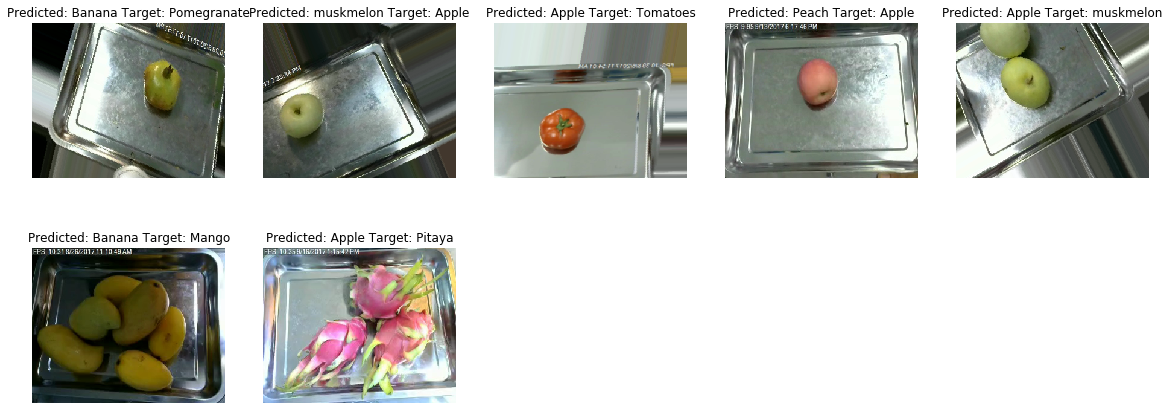

In [102]:
plt.figure(figsize=(20, 20))
for i in range(min(25,len(incorrect_class))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inv_normalize(incorrect_input[i,:]))
    plt.title('Predicted: ' + fruit_dataset.classes[incorrect_class[i]] + ' Target: ' + fruit_dataset.classes[incorrect_target[i]])
    plt.axis('off');

## Display some random images

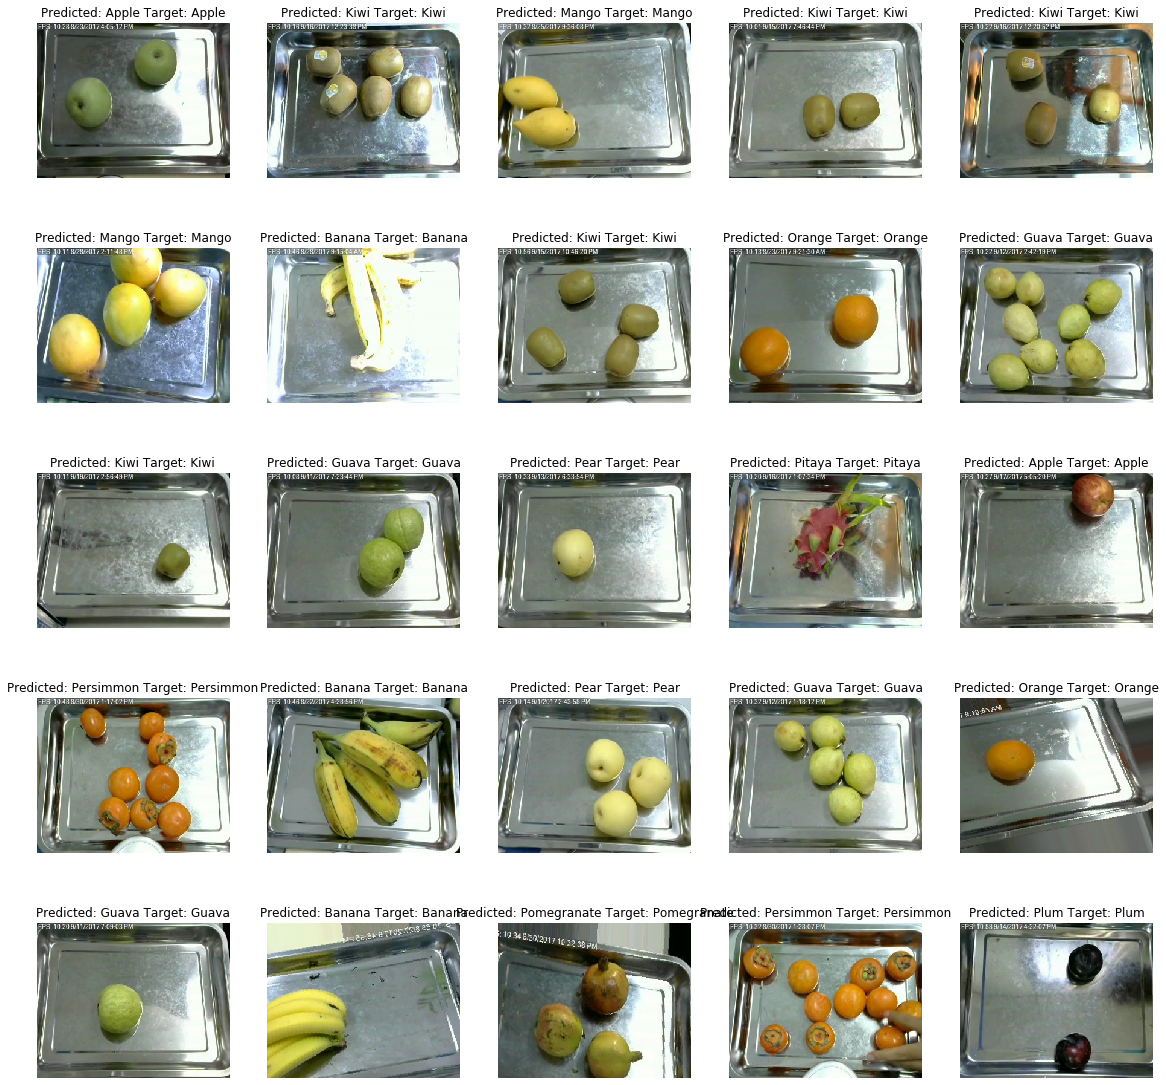

In [103]:
plt.figure(figsize=(20, 20))
for i in range(min(25,len(out_class))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inv_normalize(input[i,:].cpu()))
    plt.title('Predicted: ' + fruit_dataset.classes[out_class[i]] + ' Target: ' + fruit_dataset.classes[target[i]])
    plt.axis('off');

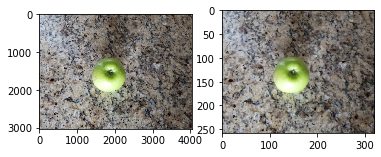

In [118]:
from PIL import Image

# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize(258),
     transforms.CenterCrop((258,320)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Renormalize images
inv_normalize = transforms.Compose(
    [transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5]),
     transforms.ToPILImage()
    ]
)

# Load test_images
img = Image.open("test_img/20200425_131613.jpg")
img_t = transform(img)
img_batch = torch.unsqueeze(img_t,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(inv_normalize(img_t))

In [119]:
with torch.no_grad():
    test_out = model(img_batch)

In [120]:
test_prob, test_class = test_out.topk(1, 1, True, True)
fruit_dataset.classes[test_class[0]]

'muskmelon'

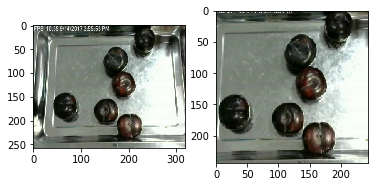

In [122]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize(258),
     transforms.CenterCrop((244,244)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load test_images
img = Image.open("data/Plum/Plum1376.png")
img_t = transform(img)
img_batch = torch.unsqueeze(img_t,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(inv_normalize(img_t))

In [123]:
with torch.no_grad():
    test_out = model(img_batch)
    
test_prob, test_class = test_out.topk(1, 1, True, True)
fruit_dataset.classes[test_class[0]]

'Plum'

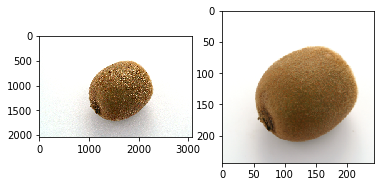

In [128]:
# Load test_images
img = Image.open("test_img/Kiwi.jpg")
img_t = transform(img)
img_batch = torch.unsqueeze(img_t,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(inv_normalize(img_t))

In [129]:
with torch.no_grad():
    test_out = model(img_batch)
    
test_prob, test_class = test_out.topk(1, 1, True, True)
fruit_dataset.classes[test_class[0]]

'Peach'

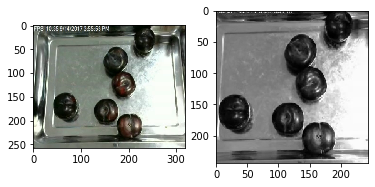

In [156]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize(258),
     transforms.CenterCrop((244,244)),
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load test_images
img = Image.open("data/Plum/Plum1376.png")
img_t = transform(img)
img_batch = torch.unsqueeze(img_t,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(inv_normalize(img_t))

In [157]:
with torch.no_grad():
    test_out = model(img_batch)
    
test_prob, test_class = test_out.topk(1, 1, True, True)
fruit_dataset.classes[test_class[0]]

'Plum'

In [160]:
# Construct Model
model = models.resnet18(pretrained=False)
# Load model from pretrained models
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('trained/resnet18_Grayscale_93.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [161]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize((258,320)),
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load fruit dataset
fruit_dataset = datasets.ImageFolder("data/",transform=transform)
fruit_dataset.classes

['Apple',
 'Banana',
 'Carambola',
 'Guava',
 'Kiwi',
 'Mango',
 'Orange',
 'Peach',
 'Pear',
 'Persimmon',
 'Pitaya',
 'Plum',
 'Pomegranate',
 'Tomatoes',
 'muskmelon']

In [162]:
# Split into validation test set
valset, _ = torch.utils.data.dataset.random_split(fruit_dataset, [1000, len(fruit_dataset) - 1000])

#Create Data Loader
val_loader = torch.utils.data.DataLoader(valset, shuffle=False, num_workers=2, pin_memory=True, batch_size=256)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

# switch to evaluate mode
model.eval()

incorrect = []

with torch.no_grad():
    # Initialize meters
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):

        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

Test: [0/4]	Time 2.852 (2.852)	Loss 0.1926 (0.1926)	Prec@1 92.969 (92.969)	Prec@5 99.609 (99.609)
 * Prec@1 93.400 Prec@5 99.700


In [163]:
out_prob, out_class = output.topk(1, 1, True, True)
bool_mask = out_class[:,-1] != target
incorrect_output = output[bool_mask,:].cpu()
incorrect_input = input[bool_mask,:].cpu()
incorrect_target = target[bool_mask].cpu()
incorrect_class = out_class[bool_mask].cpu()

#Renormalize images
inv_normalize = transforms.Compose(
    [transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5]),
     transforms.ToPILImage()
    ]
)

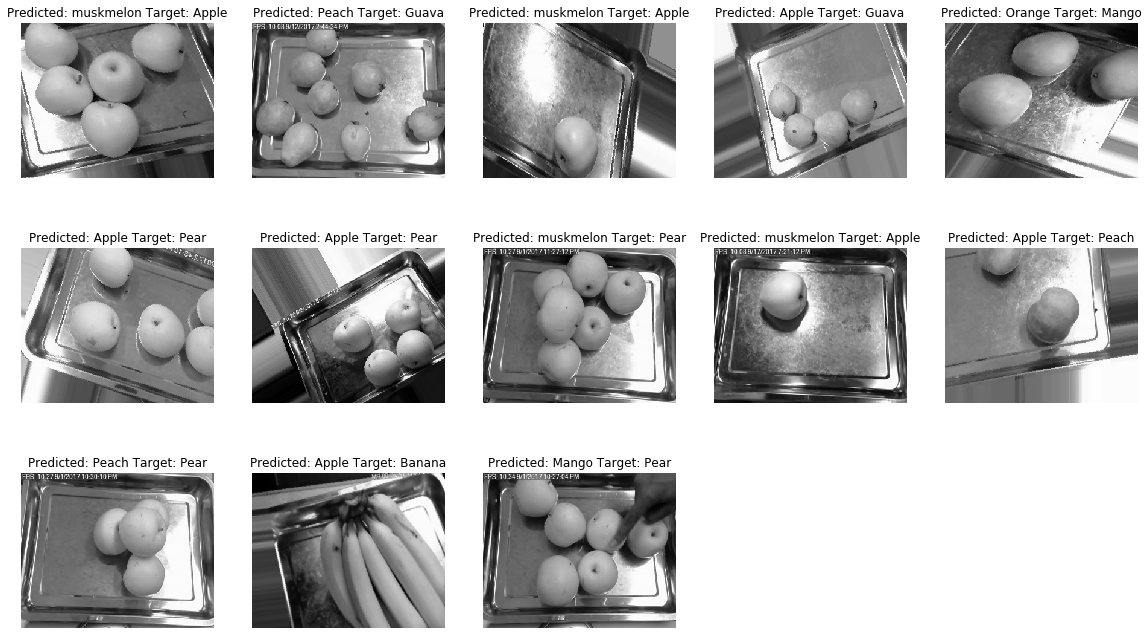

In [164]:
plt.figure(figsize=(20, 20))
for i in range(min(25,len(incorrect_class))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inv_normalize(incorrect_input[i,:]))
    plt.title('Predicted: ' + fruit_dataset.classes[incorrect_class[i]] + ' Target: ' + fruit_dataset.classes[incorrect_target[i]])
    plt.axis('off');

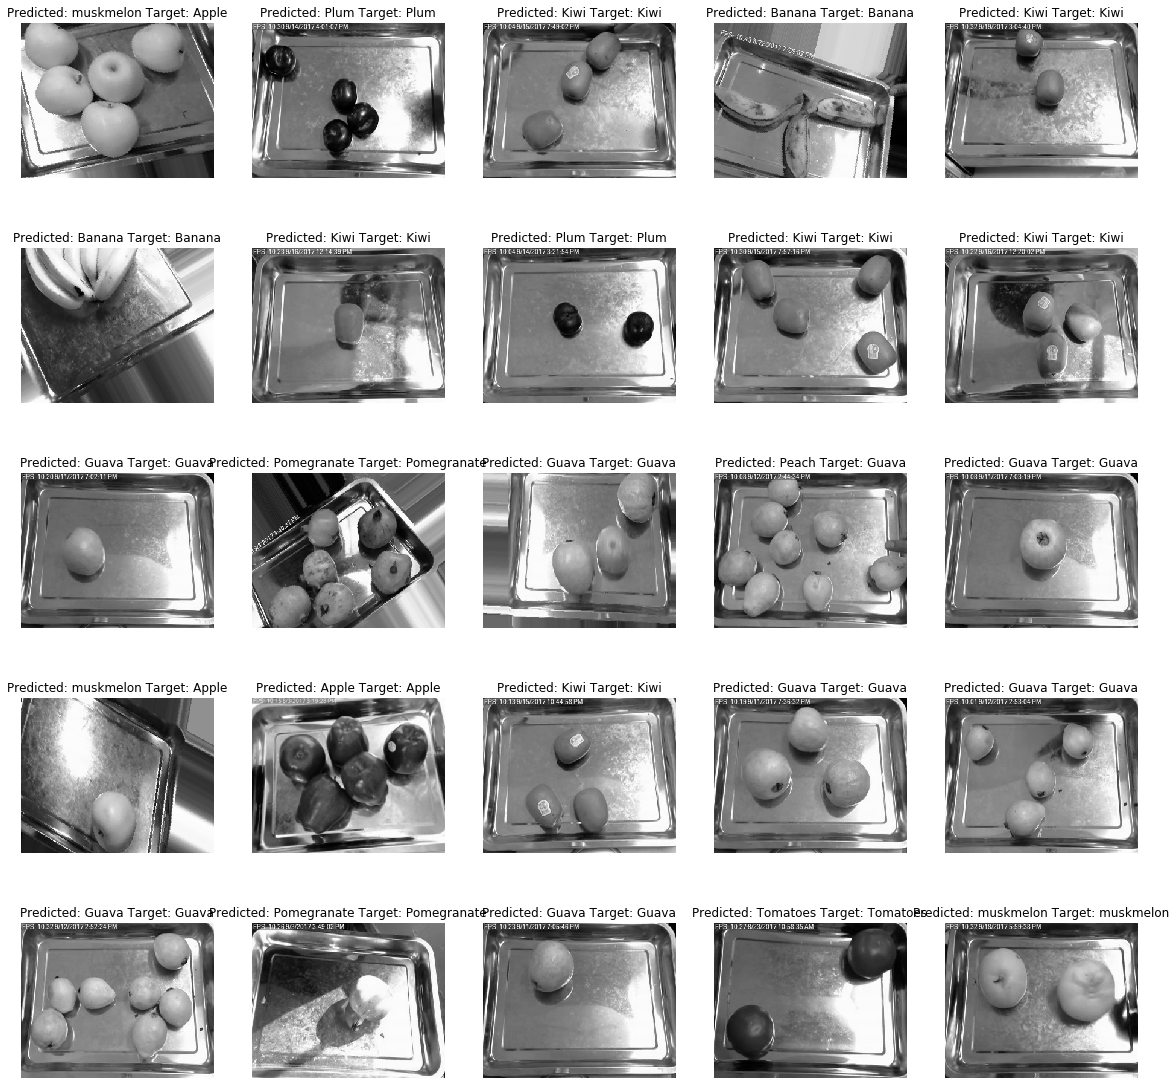

In [165]:
plt.figure(figsize=(20, 20))
for i in range(min(25,len(out_class))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(inv_normalize(input[i,:].cpu()))
    plt.title('Predicted: ' + fruit_dataset.classes[out_class[i]] + ' Target: ' + fruit_dataset.classes[target[i]])
    plt.axis('off');

'Carambola'

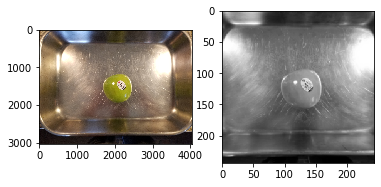

In [174]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize(258),
     transforms.CenterCrop((244,244)),
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load test_images
img = Image.open("data/Apple/Apple C/")
img_t = transform(img)
img_batch = torch.unsqueeze(img_t,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(inv_normalize(img_t))

with torch.no_grad():
    test_out = model(img_batch)
    
test_prob, test_class = test_out.topk(1, 1, True, True)
fruit_dataset.classes[test_class[0]]

'Mango'

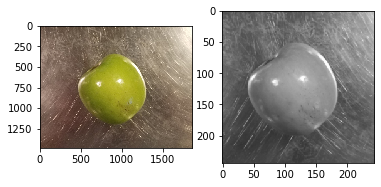

In [179]:
# Define the transform for the data. From the fruit dataset spec images should be 320x258.
transform = transforms.Compose(
    [transforms.Resize(258),
     transforms.CenterCrop((244,244)),
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load test_images
img = Image.open("test_img/AppleNoStickerCrop.jpg")
img_t = transform(img)
img_batch = torch.unsqueeze(img_t,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(inv_normalize(img_t))

with torch.no_grad():
    test_out = model(img_batch)
    
test_prob, test_class = test_out.topk(1, 1, True, True)
fruit_dataset.classes[test_class[0]]

## Image normalization

In [ ]:
fruit_dataset = datasets.ImageFolder("data/")